# New dataset: Boston housing

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

from src.data.utils import load_boston_dataset
from src.visualization import beautify_ax
from src.models import (
    ModelTrainer, BayesianLinearRegression, 
    QuantileRegressionMCDropoutNet, HeteroscedasticMCDropoutNet
)
from src.models.quantile_utils import create_quantiles

%load_ext autoreload
%autoreload 2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Loading the data

In [2]:
df = load_boston_dataset(return_df=True)

In [3]:
x_train, x_test, y_train, y_test = load_boston_dataset()

## Little data exploration

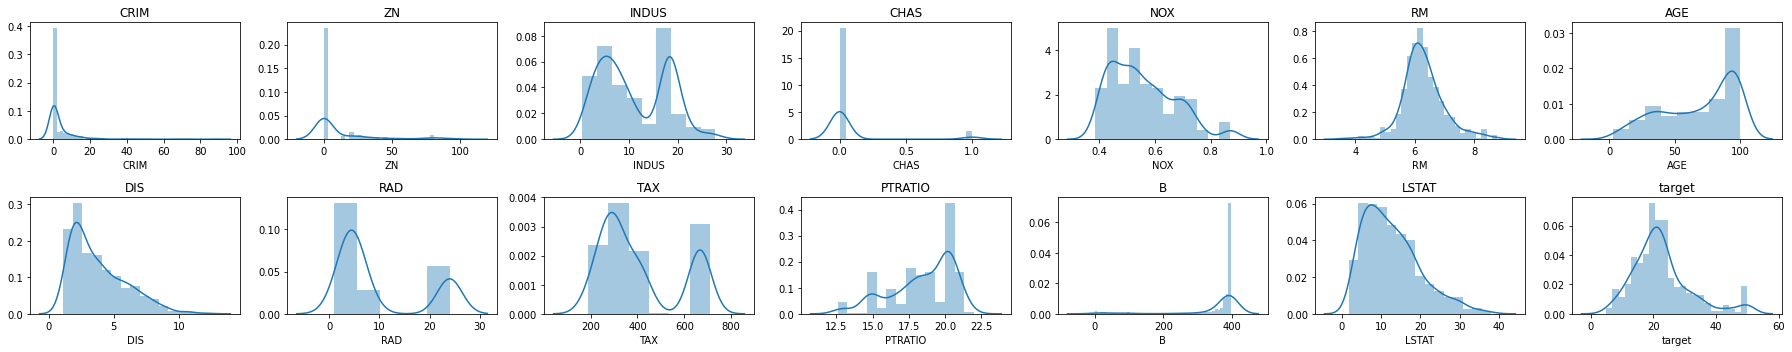

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(25,5))
for i, ax in enumerate(axes.flatten()):
    sns.distplot(df.iloc[:, i], ax=ax)
    ax.set_title(df.columns[i])
    
plt.tight_layout()

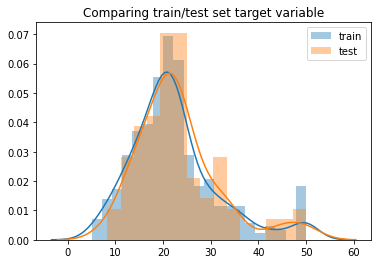

In [5]:
sns.distplot(y_train, label='train')
sns.distplot(y_test, label='test')
plt.title('Comparing train/test set target variable')
plt.legend();

In [6]:
QUANTILES = create_quantiles(11, min_q=0.01, max_q=0.99)
QRMCDN_params = {'input_size': x_train.shape[1], 'hidden_size': 128, 'dropout_p': 0.2, 'quantiles': QUANTILES, 'dropout_dim': 1}
HMCDN_params  = {'input_size': x_train.shape[1], 'hidden_size': 256, 'dropout_p': 0.2}
BLR_params = {'input_size': x_train.shape[1]}

models = {
    "QRMCDN": QuantileRegressionMCDropoutNet(QRMCDN_params),
    "HMCDN": HeteroscedasticMCDropoutNet(HMCDN_params),
    "BLR": BayesianLinearRegression(BLR_params)
}

trainer = ModelTrainer(models, model_path='../models/')

In [7]:
fit_kwargs = {
    "QRMCDN": {'batch_size': 64, 'epochs': 501, 'print_iter': 50, 'lr': 1e-4},
    "HMCDN": {'batch_size': 64, 'epochs': 501, 'print_iter': 50, 'lr': 1e-4, 'weight_decay': 1e-6},
    "BLR": {'samples': 1000, 'tune':1000, 'init':'adapt_diag'}
}

save_kwargs = {
    "BLR": {'overwrite': True}
}
trainer.train(x_train, y_train, fit_kwargs, save_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:35<00:00, 170.05draws/s]


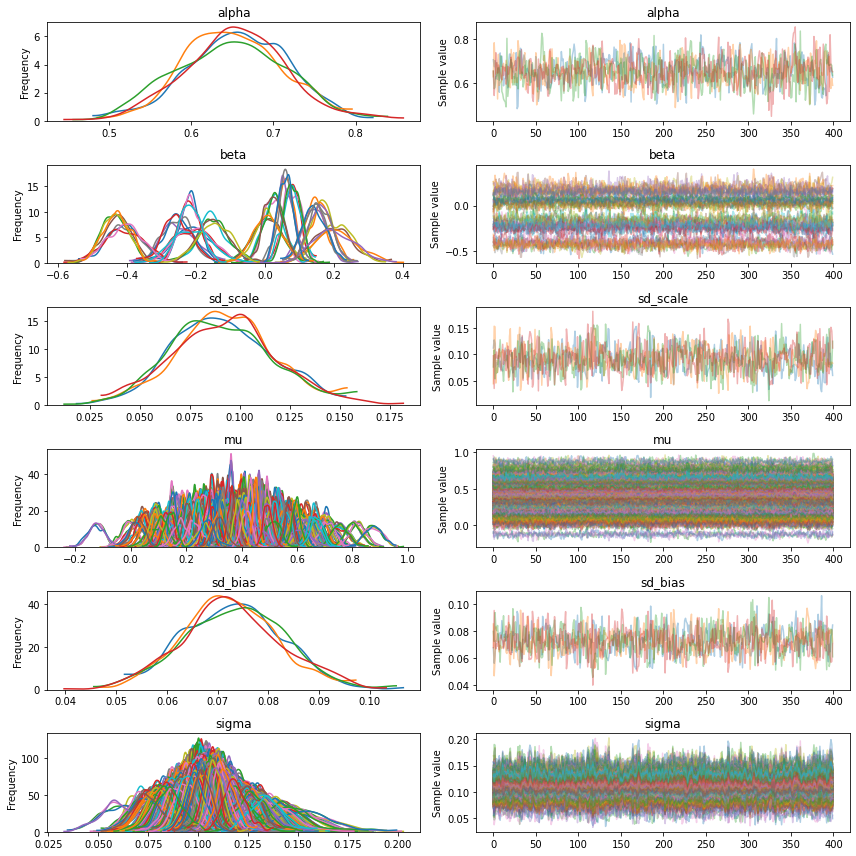

In [8]:
models['BLR'].plot_trace(skip_first_n=100)

In [9]:
predict_kwargs = {"BLR": {'quantiles': QUANTILES},
                  "HMCDN": {'quantiles': QUANTILES}}

qpreds = trainer.generate_quantile_predictions(x_test, predict_kwargs)

100%|██████████| 2000/2000 [00:33<00:00, 60.09it/s]


### Selecting some random test cases

In [10]:
random_is = np.random.randint(0, len(x_test), 9)

### Plotting the quantile predictions

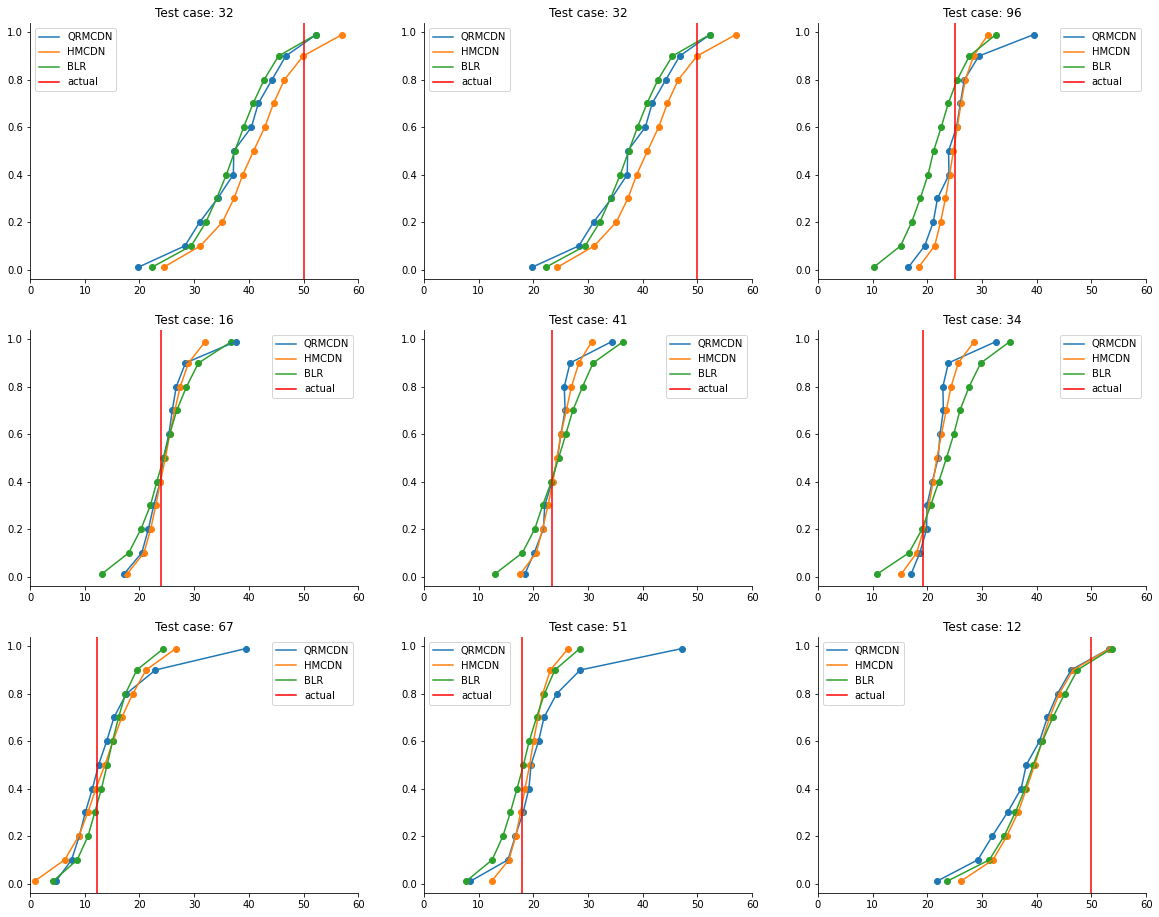

In [11]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for m_name, preds in qpreds.items():
        ax.plot(preds[i], QUANTILES, label=m_name)
        ax.scatter(preds[i], QUANTILES)

    ax.axvline(y_test[i], c='r', label='actual')
    ax.set_title(f"Test case: {i}")
    ax.legend()
    ax.set_xlim(0, 60)

plt.show()

## Secondly, generating distributions

The other way around. Create an approximate posterior distribution from the output of the `QuantileRegressionMCDropoutNet`. Then we can compare it with the output from the `BayesianLinearRegression` and the `HeteroscedasticMCDropoutNet.

In [12]:
posterior_samples = trainer.generate_posterior_samples(x_train, sample_kwargs={'BLR': {'samples': 1000}})

print(*(f'{name}: {output.shape}' for name, output in posterior_samples.items()))

100%|██████████| 1000/1000 [00:17<00:00, 58.24it/s]

QRMCDN: (404, 1000) HMCDN: (404, 1000) BLR: (404, 1000)


### Plotting the approximate posterior distributions

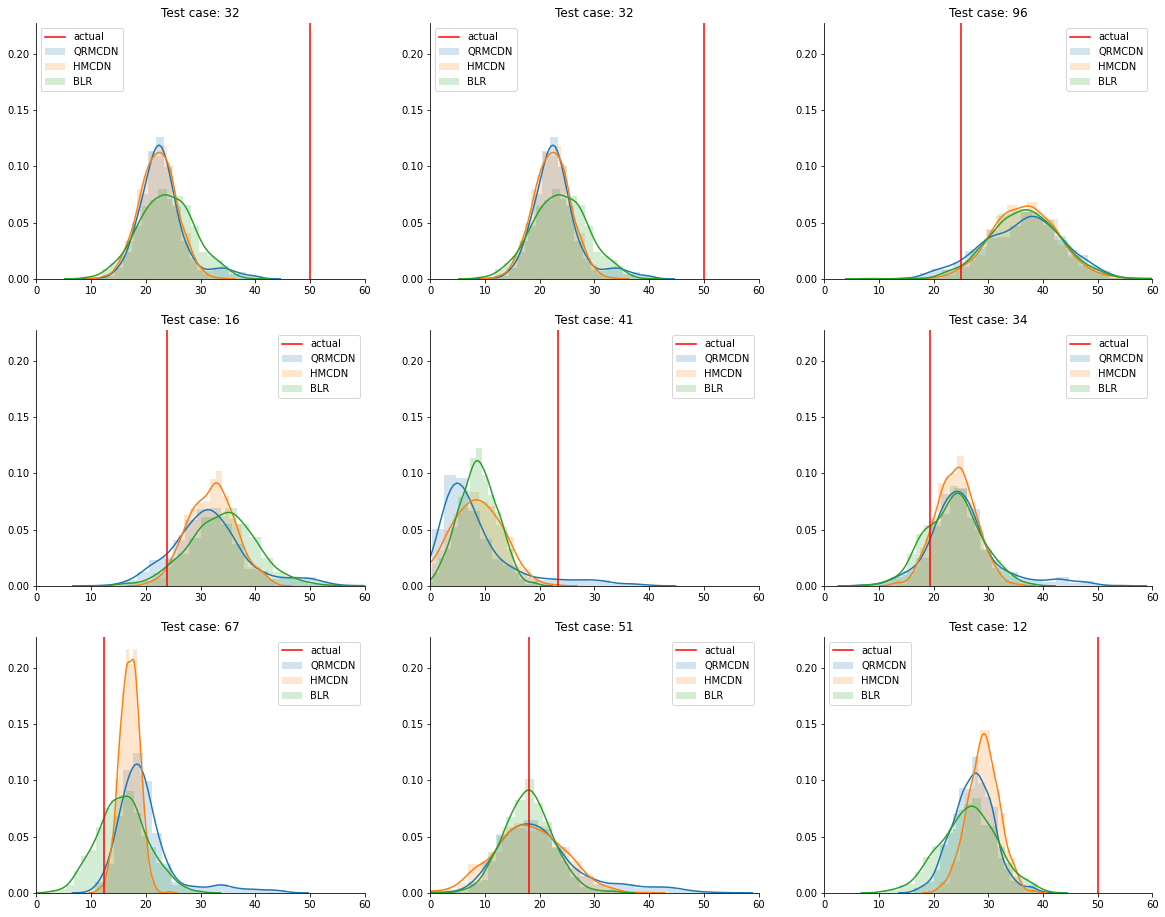

In [13]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))

for i, ax in zip(random_is, axes.flat):
    ax = beautify_ax(ax)
    
    for m_name, samples in posterior_samples.items():
        sns.distplot(samples[i], bins=20, label=m_name, hist_kws={'alpha':0.2}, ax=ax)
    
    ax.set_title(f"Test case: {i}")
    ax.axvline(y_test[i], c='r', label='actual')
    ax.legend()
    ax.set_xlim(0, 60)
    
plt.show()